### Setup & Imports

In [ ]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from scipy.spatial.distance import euclidean

# Machine Learning
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# PSO for optimization
from pyswarm import pso

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Load Saved Feature Matrix

In [127]:
# Load sparse matrix
final_features = sparse.load_npz("final_features_sparse.npz")
print("Loaded feature matrix shape:", final_features.shape)

# Load original dataset to map cluster labels back to reviews
df = pd.read_csv("processed_reviews.csv")
print("Dataset shape:", df.shape)

Loaded feature matrix shape: (40432, 10001)
Dataset shape: (40432, 3)


### PCA Visualization

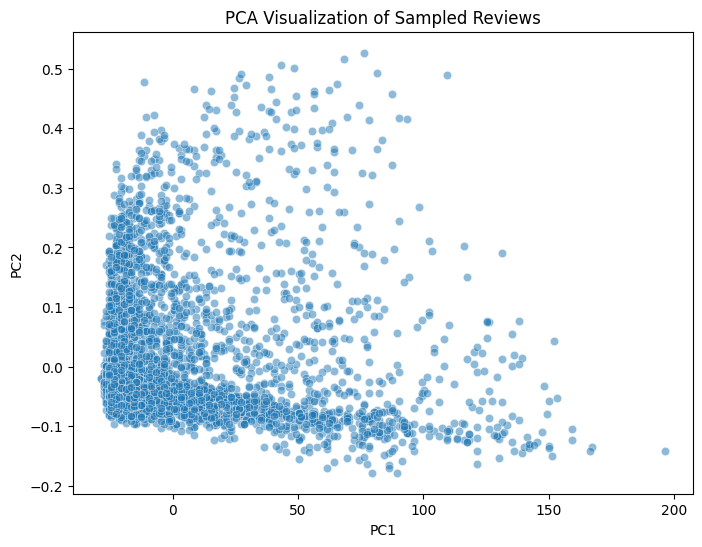

In [128]:
sample_size = 5000
if final_features.shape[0] > sample_size:
    sampled_indices = np.random.choice(final_features.shape[0], sample_size, replace=False)
    sampled_features = final_features[sampled_indices].toarray()
    sampled_df = df.iloc[sampled_indices].reset_index(drop=True)
else:
    sampled_features = final_features.toarray()
    sampled_df = df.copy()

pca = PCA(n_components=2)
features_2d = pca.fit_transform(sampled_features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_2d[:,0], y=features_2d[:,1], alpha=0.5)
plt.title("PCA Visualization of Sampled Reviews")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### PSO to Find Optimal Number of Clusters

In [129]:
def objective_function(k):
    k = int(k[0])
    if k < 2: return 999999
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048)
    km.fit(final_features)
    sample_size = min(5000, final_features.shape[0])
    sample_indices = np.random.choice(final_features.shape[0], sample_size, replace=False)
    score = silhouette_score(final_features[sample_indices], km.labels_[sample_indices])
    return -score

lb, ub = [2], [10]
best_k, best_score = pso(objective_function, lb, ub, swarmsize=10, maxiter=5)
best_k = int(best_k[0])
print(f"Optimal k: {best_k}, silhouette score: {-best_score:.4f}")

Stopping search: maximum iterations reached --> 5
Optimal k: 2, silhouette score: 0.7609


### Final K-Means Clustering with Optimal k

In [130]:
kmeans_final = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=2048, max_iter=100)
kmeans_final.fit(final_features)
df['cluster'] = kmeans_final.labels_

### Distance-based Anomaly Detection

In [131]:
distances = []
for i in range(final_features.shape[0]):
    cluster = df.loc[i, 'cluster']
    centroid = kmeans_final.cluster_centers_[cluster]
    # Flatten sparse row to 1D array
    dist = euclidean(final_features[i].toarray().ravel(), centroid)
    distances.append(dist)

df['distance_to_centroid'] = distances
threshold = np.percentile(distances, 95)  # top 5% farthest points = anomalous
df['review_type'] = df['distance_to_centroid'].apply(lambda x: 'Anomalous' if x > threshold else 'Normal')

### Visualize PCA with Anomaly

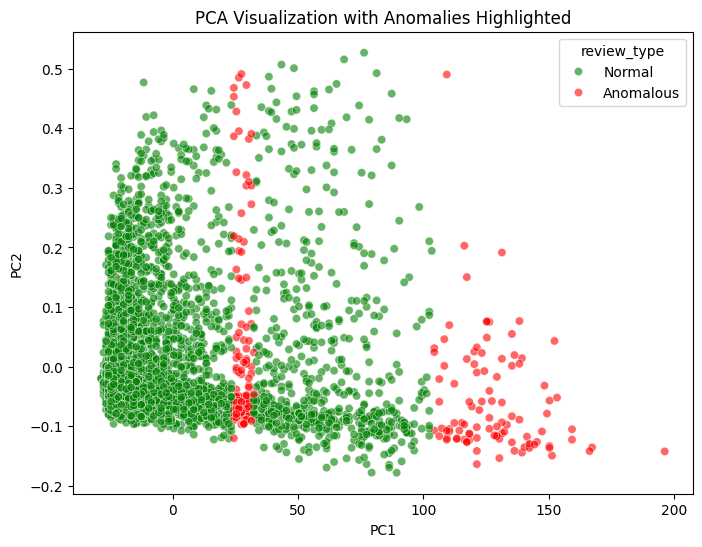

In [132]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=features_2d[:,0], y=features_2d[:,1], hue=df['review_type'].iloc[sampled_indices], palette=['green','red'], alpha=0.6)
plt.title("PCA Visualization with Anomalies Highlighted")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Extract Top Keywords per Cluster

In [133]:

# Convert the string representation of a list into a single string
df['Review_Text_joined'] = df['processed_review'].apply(
    lambda tokens: ' '.join(eval(tokens)) if isinstance(tokens, str) else ' '.join(tokens)
)

# Example
print(df['Review_Text_joined'].head())

# Fit TF-IDF on the original reviews
vectorizer = TfidfVectorizer()
vectorizer.fit(df['Review_Text_joined'])
feature_names = vectorizer.get_feature_names_out()

# Get cluster centers
centroids = kmeans_final.cluster_centers_

# Function to get top n keywords per cluster
def get_top_keywords_per_cluster(centroids, feature_names, n=10):
    top_keywords = {}
    for i, centroid in enumerate(centroids):
        top_idx = centroid.argsort()[::-1][:n]  # Indices of top n features
        top_keywords[i] = [feature_names[idx] for idx in top_idx]
    return top_keywords

top_keywords = get_top_keywords_per_cluster(centroids, feature_names, n=10)

# Display top keywords for each cluster
print("\nTop keywords per cluster:")
for cluster, keywords in top_keywords.items():
    print(f"Cluster {cluster}: {keywords}")


0    love well made sturdy comfortable love itvery ...
1     love great upgrade original ive mine couple year
2              pillow saved back love look feel pillow
3          missing information use great product price
4                  nice set good quality set two month
Name: Review_Text_joined, dtype: object

Top keywords per cluster:
Cluster 0: ['consider', 'bamboo', 'anchovy', '216', 'amazingeverything', 'biorhythm', 'comfortably', 'chalking', 'brillient', 'compliant']
Cluster 1: ['consider', '216', 'biorhythm', 'conan', 'amazingeverything', 'awaiting', 'chalking', 'bamboo', 'anchovy', 'brillient']


### Create Summary Table

In [134]:
cluster_summary = pd.DataFrame({
    'cluster': range(best_k),
    'size': [sum(df['cluster'] == i) for i in range(best_k)],
    'top_keywords': [', '.join(top_keywords[i]) for i in range(best_k)]
})
print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
   cluster   size                                       top_keywords
0        0  34076  consider, bamboo, anchovy, 216, amazingeveryth...
1        1   6356  consider, 216, biorhythm, conan, amazingeveryt...


### Save Results

In [135]:
df.to_csv("clustered_reviews.csv", index=False)
print("Clustered dataset saved to clustered_reviews.csv")

Clustered dataset saved to clustered_reviews.csv


### Save Models for Prediction

In [136]:
joblib.dump(kmeans_final, "kmeans_model.pkl")
joblib.dump(threshold, "anomaly_distance_threshold.pkl")
print("Models saved successfully for prediction!")

Models saved successfully for prediction!
